In [4]:
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import imageio
from scipy import misc
import numpy as np
import os

Using TensorFlow backend.


In [9]:
json_file = open("model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_weights = loaded_model.load_weights("model.h5")
print("Loaded Pneumonia Prediction model from disk")

Loaded Pneumonia Prediction model from disk


In [10]:
new_image = misc.imread("testimage.jpeg",mode='RGB')
new_xray_image = misc.imresize(new_image,(150,150,3))
x = np.expand_dims(new_xray_image, axis=0)
result = loaded_model.predict(x)
print("RESULT: {}".format(result))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


RESULT: [[1.2555777e-31]]


## Load Test Set (Last Validation dataset) (NON USED)

In [53]:
base_dir = 'data'
test_dir = os.path.join(base_dir, 'test')
val_datagen = ImageDataGenerator(1./255)
val_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size =1,
    class_mode= 'binary')

Found 624 images belonging to 2 classes.


In [51]:
predictions = loaded_model.predict_generator(val_generator)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/preprocessing/image.py:594: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


## Preprocess Test Data

In [41]:
infected_list = list(map(lambda name: 'data/test/PNEUMONIA/'+name, os.listdir('data/test/PNEUMONIA')))
len(infected_list)

390

In [42]:
healthy_list = list(map(lambda name: 'data/test/NORMAL/'+name, os.listdir('data/test/NORMAL')))
len(healthy_list)

234

In [43]:
class_names = ['healthy', 'pneuomonia']

In [44]:
from query_model import KerasModel
pneumoniaPredictor = KerasModel("model.json", "model.h5")

Loaded Pneumonia Prediction model from disk


In [45]:
images = infected_list + healthy_list

In [80]:
y_test_cnn = list(np.ones(len(infected_list))) + list(np.zeros(len(healthy_list)))
y_predict_cnn = pneumoniaPredictor.predict_multiple(images)


## Build Confusion matrix

In [47]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [79]:
y_output = [x['prediction'] for x in y_predict_cnn]
combination = list(zip(y_test_cnn, y_output))
print(len(combination))
false_negatives = len(list(filter(lambda x: x[0] == 1 and x[1] == 0, combination)))/len(combination)
print("False negatives ", false_negatives)


624
False negatives  0.08012820512820513


## SVM Fast Evaluation

In [12]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


## Build and Plot Confusion Matrix

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + cm.sum(axis=0)[:, np.newaxis])
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[146  88]
 [ 50 340]]
Normalized confusion matrix
[[0.34 0.2 ]
 [0.06 0.42]]


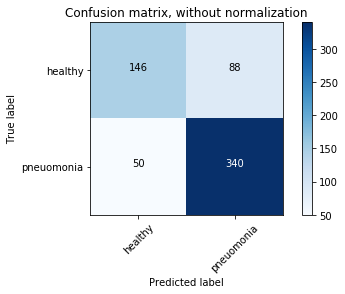

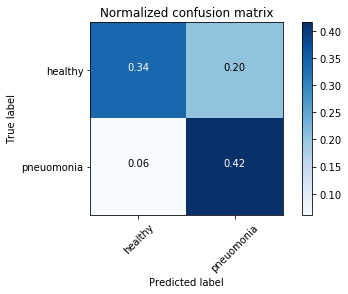

In [66]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_cnn, y_output)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Get data from folders and classes